# `random_algebra`

### Random Variable Algebra With SciPy Probability Distributions

This is intended to be a small library that extends `scipy.stats` that facilitates some simple algebra with random variables (without having to resort to a monte-carlo approach) using numerical integration from `scipy.optimize`.

With the simple statement,

```python
import random_algebra
```

we monkeypatch the `scipy.stats.rv_frozen` class that is inherited by all frozen probability distributions. 

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=1.3)

from random_algebra import posterior, scale, add, offset, plot_dist

from scipy.stats import beta, uniform, norm

Then, simple linear functions of the distribution objects result in new probability distribution objects. For example, here `c` is a random variable that is distribute like the difference between two beta distributed variables:

In [2]:
a = beta(4,1)
b = beta(10,4)
c = a - b

Inequalities operated on these objects result in probabilites that the inequality is true. Additionally, since these objects can quickly become complex, and hence computationally intensive, we can export normal approximations to these objects at any time.

In [3]:
print("P(a > b) = %.3f numerical calculation" % (a > b))
print("P(a > b) = %.3f normal approximation" % ((a - b).get_normal_approx() > 0))

P(a > b) = 0.700 numerical calculation
P(a > b) = 0.665 normal approximation


I have included a simple plot function to compare a probability distribution with an empirically generated histogram of samples from that distribution, and the normal approximation to that distribution.

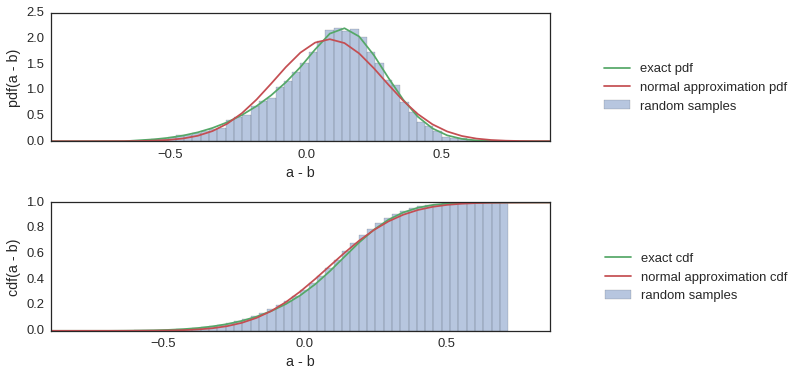

In [4]:
plot_types = ["pdf", "cdf"]

for i, plot_type in enumerate(plot_types):
    plt.subplot(len(plot_types), 1, i + 1)
    
    plot_dist(c,
              n=35, samples=20000,
              type=plot_type)
    
    plt.xlabel('a - b')
    plt.ylabel(plot_type + '(a - b)')
    
plt.tight_layout()

Here is another example in which case we are computing the difference between two uniform distributions of different widths.

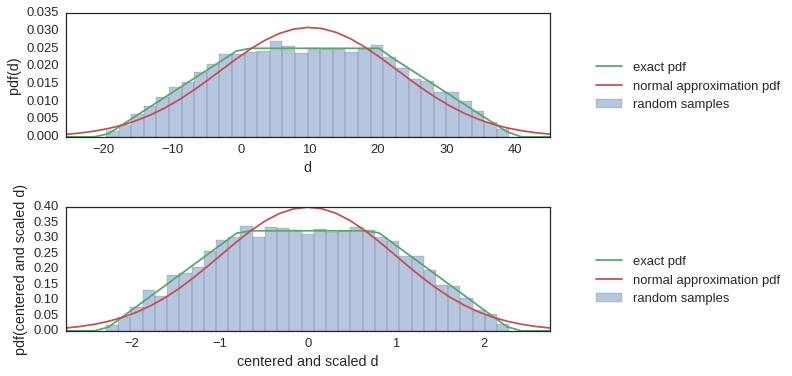

In [5]:
d = 20 * (2 * uniform() - uniform())

plt.subplot(2,1,1)
plot_dist(d)
plt.ylabel("pdf(d)")
plt.xlabel('d')

centered_and_scaled_d = (d - d.mean())/d.std()

plt.subplot(2,1,2)
plot_dist(centered_and_scaled_d)
plt.ylabel("pdf(centered and scaled d)")
plt.xlabel('centered and scaled d')

plt.tight_layout()

Using the `random_algebra.posterior` we can generate posterior distributions as per Bayes theorem as well.

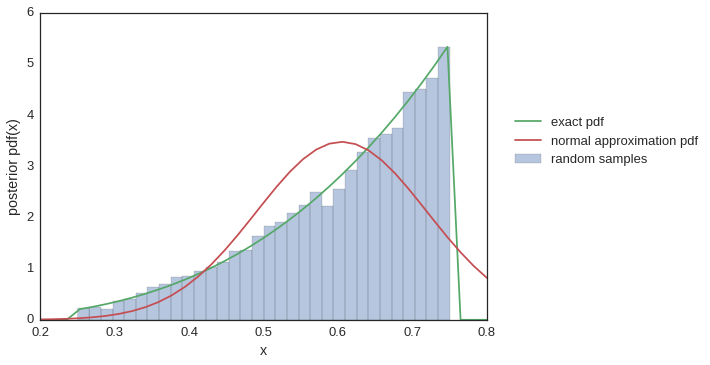

In [6]:
prior_dist      = uniform(.25, .5)
likelihood_dist = beta(4, 1)

posterior_dist  = posterior(likelihood_dist, prior_dist)

plot_dist(posterior_dist)
plt.xlabel('x')
_ = plt.ylabel('posterior pdf(x)')